In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [13]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import geopandas as gpd
from shapely.geometry import Point, Polygon
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [6]:
# Function to create sample satellite data (pixel-based features)
def create_sample_mangrove_data(n_samples=1000):
    """
    Create synthetic satellite data with spectral bands
    Real bands: B2 (Blue), B3 (Green), B4 (Red), B5 (NIR), B6 (SWIR1), B7 (SWIR2)
    """
    data = []

    # Mangrove pixels (label = 1)
    for i in range(n_samples // 2):
        # Mangroves typically have specific spectral signatures
        # High NIR (healthy vegetation), specific SWIR responses
        row = {
            'latitude': np.random.uniform(21.5, 22.5),  # Sundarbans region
            'longitude': np.random.uniform(89, 90),
            'blue': np.random.normal(0.15, 0.03),
            'green': np.random.normal(0.12, 0.02),
            'red': np.random.normal(0.10, 0.02),
            'nir': np.random.normal(0.35, 0.05),  # Higher NIR for vegetation
            'swir1': np.random.normal(0.08, 0.02),
            'swir2': np.random.normal(0.05, 0.01),
            'ndvi': np.random.uniform(0.6, 0.8),  # High NDVI for mangroves
            'ndwi': np.random.uniform(0.2, 0.4),  # Water content index
            'label': 1  # Mangrove
        }
        data.append(row)

    # Non-mangrove pixels (label = 0)
    for i in range(n_samples // 2):
        # Could be water, urban, other vegetation, barren land
        pixel_type = np.random.choice(['water', 'urban', 'other_veg', 'barren'])

        if pixel_type == 'water':
            row = {
                'latitude': np.random.uniform(21.5, 22.5),
                'longitude': np.random.uniform(89, 90),
                'blue': np.random.normal(0.25, 0.05),  # Higher blue for water
                'green': np.random.normal(0.20, 0.04),
                'red': np.random.normal(0.10, 0.03),
                'nir': np.random.normal(0.05, 0.02),  # Very low NIR
                'swir1': np.random.normal(0.03, 0.01),
                'swir2': np.random.normal(0.02, 0.01),
                'ndvi': np.random.uniform(-0.1, 0.1),  # Low/negative NDVI
                'ndwi': np.random.uniform(0.6, 0.9),  # High NDWI for water
                'label': 0
            }
        elif pixel_type == 'urban':
            row = {
                'latitude': np.random.uniform(21.5, 22.5),
                'longitude': np.random.uniform(89, 90),
                'blue': np.random.normal(0.20, 0.04),
                'green': np.random.normal(0.18, 0.03),
                'red': np.random.normal(0.25, 0.04),  # Higher red for urban
                'nir': np.random.normal(0.15, 0.03),
                'swir1': np.random.normal(0.20, 0.04),
                'swir2': np.random.normal(0.15, 0.03),
                'ndvi': np.random.uniform(0.1, 0.3),  # Moderate NDVI
                'ndwi': np.random.uniform(-0.1, 0.1),
                'label': 0
            }
        elif pixel_type == 'other_veg':
            row = {
                'latitude': np.random.uniform(21.5, 22.5),
                'longitude': np.random.uniform(89, 90),
                'blue': np.random.normal(0.15, 0.03),
                'green': np.random.normal(0.18, 0.03),
                'red': np.random.normal(0.12, 0.02),
                'nir': np.random.normal(0.30, 0.04),  # High NIR
                'swir1': np.random.normal(0.10, 0.02),
                'swir2': np.random.normal(0.07, 0.02),
                'ndvi': np.random.uniform(0.5, 0.7),
                'ndwi': np.random.uniform(0.1, 0.3),
                'label': 0
            }
        else:  # barren
            row = {
                'latitude': np.random.uniform(21.5, 22.5),
                'longitude': np.random.uniform(89, 90),
                'blue': np.random.normal(0.25, 0.05),
                'green': np.random.normal(0.22, 0.04),
                'red': np.random.normal(0.25, 0.04),
                'nir': np.random.normal(0.20, 0.03),
                'swir1': np.random.normal(0.25, 0.04),
                'swir2': np.random.normal(0.20, 0.03),
                'ndvi': np.random.uniform(0.0, 0.2),  # Low NDVI
                'ndwi': np.random.uniform(-0.2, 0.0),
                'label': 0
            }

        data.append(row)

    return pd.DataFrame(data)

# Create sample dataset
df = create_sample_mangrove_data(2000)
print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['label'].value_counts())
print(f"Mangrove samples: {df['label'].sum()} ({df['label'].mean():.1%})")

Dataset shape: (2000, 11)

Class distribution:
label
1    1000
0    1000
Name: count, dtype: int64
Mangrove samples: 1000 (50.0%)


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   2000 non-null   float64
 1   longitude  2000 non-null   float64
 2   blue       2000 non-null   float64
 3   green      2000 non-null   float64
 4   red        2000 non-null   float64
 5   nir        2000 non-null   float64
 6   swir1      2000 non-null   float64
 7   swir2      2000 non-null   float64
 8   ndvi       2000 non-null   float64
 9   ndwi       2000 non-null   float64
 10  label      2000 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 172.0 KB
None

Summary Statistics:
          latitude    longitude         blue        green          red  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean     21.998137    89.495332     0.182102     0.157942     0.141085   
std       0.287870     0.288102     0.057079     0.049040 

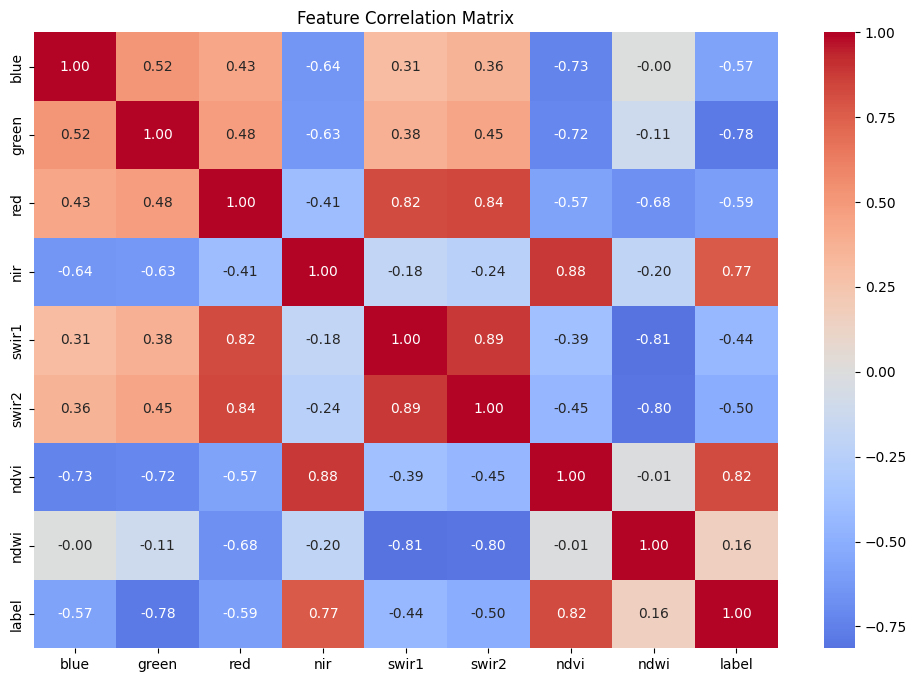

In [7]:
# 1. Basic Statistics
print("Dataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

# 2. Spectral Band Visualization
fig = make_subplots(
    rows=3, cols=3,
    subplot_titles=('Blue Band', 'Green Band', 'Red Band',
                    'NIR Band', 'SWIR1 Band', 'SWIR2 Band',
                    'NDVI', 'NDWI', 'Class Distribution'),
    vertical_spacing=0.1
)

# Spectral bands
bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'ndvi', 'ndwi']
colors = ['blue', 'green', 'red', 'darkred', 'orange', 'brown', 'lime', 'cyan']

for i, (band, color) in enumerate(zip(bands, colors)):
    row = i // 3 + 1
    col = i % 3 + 1

    fig.add_trace(
        go.Histogram(
            x=df[band],
            name=band.upper(),
            marker_color=color,
            opacity=0.7
        ),
        row=row, col=col
    )

# Class distribution
fig.add_trace(
    go.Bar(
        x=['Non-Mangrove', 'Mangrove'],
        y=df['label'].value_counts().sort_index().values,
        marker_color=['red', 'green'],
        text=df['label'].value_counts().sort_index().values,
        textposition='auto'
    ),
    row=3, col=3
)

fig.update_layout(height=900, showlegend=False, title_text="Spectral Band Distributions")
fig.show()

# 3. Correlation Matrix
plt.figure(figsize=(12, 8))
corr_matrix = df.drop(['latitude', 'longitude'], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

# 4. Spectral Signature Plot
mangrove_mean = df[df['label'] == 1][bands].mean()
non_mangrove_mean = df[df['label'] == 0][bands].mean()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=bands,
    y=mangrove_mean,
    mode='lines+markers',
    name='Mangrove',
    line=dict(color='green', width=3),
    marker=dict(size=10)
))
fig.add_trace(go.Scatter(
    x=bands,
    y=non_mangrove_mean,
    mode='lines+markers',
    name='Non-Mangrove',
    line=dict(color='red', width=3),
    marker=dict(size=10)
))

fig.update_layout(
    title='Average Spectral Signatures',
    xaxis_title='Spectral Bands',
    yaxis_title='Reflectance',
    template='plotly_white',
    height=500
)
fig.show()

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Prepare features and labels
features = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'ndvi', 'ndwi']
X = df[features]
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Random Forest Classifier
print("=" * 60)
print("RANDOM FOREST CLASSIFIER")
print("=" * 60)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Non-Mangrove', 'Mangrove']))

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# 2. Logistic Regression
print("\n" + "=" * 60)
print("LOGISTIC REGRESSION")
print("=" * 60)

lr_model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    random_state=42
)

lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Non-Mangrove', 'Mangrove']))

# 3. Support Vector Machine
print("\n" + "=" * 60)
print("SUPPORT VECTOR MACHINE")
print("=" * 60)

svm_model = SVC(
    C=1.0,
    kernel='rbf',
    probability=True,
    random_state=42
)

svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Non-Mangrove', 'Mangrove']))

Training samples: 1400
Testing samples: 600
RANDOM FOREST CLASSIFIER
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

Non-Mangrove       1.00      1.00      1.00       300
    Mangrove       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600


Feature Importance:
  feature  importance
1   green    0.324128
6    ndvi    0.236725
3     nir    0.150807
5   swir2    0.104320
7    ndwi    0.102986
2     red    0.034978
4   swir1    0.031400
0    blue    0.014655

LOGISTIC REGRESSION
Accuracy: 0.9900

Classification Report:
              precision    recall  f1-score   support

Non-Mangrove       1.00      0.98      0.99       300
    Mangrove       0.98      1.00      0.99       300

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted a

In [9]:
# Create sample region data (for demonstration)
def create_region_data():
    """Create sample region data with mangrove coverage percentages"""
    regions = {
        'Sundarbans (Bangladesh)': {'lat': 21.95, 'lon': 89.18, 'coverage': 85, 'area_km2': 6017},
        'Sundarbans (India)': {'lat': 21.73, 'lon': 88.87, 'coverage': 70, 'area_km2': 4260},
        'Mekong Delta (Vietnam)': {'lat': 9.28, 'lon': 105.73, 'coverage': 65, 'area_km2': 2300},
        'Amazon Delta (Brazil)': {'lat': -1.47, 'lon': -48.47, 'coverage': 75, 'area_km2': 8900},
        'Florida (USA)': {'lat': 25.76, 'lon': -80.19, 'coverage': 40, 'area_km2': 1800},
        'Indonesia': {'lat': -2.50, 'lon': 118.00, 'coverage': 80, 'area_km2': 31000},
        'Malaysia': {'lat': 4.21, 'lon': 101.98, 'coverage': 60, 'area_km2': 6416},
        'Philippines': {'lat': 12.88, 'lon': 121.77, 'coverage': 45, 'area_km2': 2475},
        'Australia': {'lat': -16.92, 'lon': 145.77, 'coverage': 55, 'area_km2': 9775},
        'Madagascar': {'lat': -18.77, 'lon': 46.85, 'coverage': 35, 'area_km2': 3200}
    }

    df_regions = pd.DataFrame.from_dict(regions, orient='index')
    df_regions = df_regions.reset_index().rename(columns={'index': 'region'})
    return df_regions

df_regions = create_region_data()

# 1. Choropleth Map (Interactive World Map)
fig = px.scatter_geo(
    df_regions,
    lat='lat',
    lon='lon',
    size='area_km2',
    color='coverage',
    hover_name='region',
    hover_data={'coverage': True, 'area_km2': True, 'lat': False, 'lon': False},
    size_max=30,
    color_continuous_scale='Viridis',
    title='Mangrove Coverage by Region (Choropleth Visualization)',
    projection='natural earth'
)

fig.update_geos(
    showcoastlines=True,
    coastlinecolor="LightGray",
    showland=True,
    landcolor="WhiteSmoke",
    showocean=True,
    oceancolor="LightBlue"
)

fig.update_layout(height=600)
fig.show()

# 2. Prediction Map for Sample Area
# Create grid for prediction visualization
def create_prediction_map(model, region_lat=21.95, region_lon=89.18, grid_size=50):
    """Create a prediction map for a specific region"""
    # Create grid
    lat_range = np.linspace(region_lat - 0.2, region_lat + 0.2, grid_size)
    lon_range = np.linspace(region_lon - 0.2, region_lon + 0.2, grid_size)

    predictions = []
    for lat in lat_range:
        for lon in lon_range:
            # Simulate spectral values based on location
            # In reality, these would come from satellite data
            is_mangrove_zone = (abs(lat - region_lat) < 0.1 and abs(lon - region_lon) < 0.1)

            if is_mangrove_zone:
                features = np.array([[
                    np.random.normal(0.15, 0.02),  # blue
                    np.random.normal(0.12, 0.02),  # green
                    np.random.normal(0.10, 0.02),  # red
                    np.random.normal(0.35, 0.04),  # nir
                    np.random.normal(0.08, 0.02),  # swir1
                    np.random.normal(0.05, 0.01),  # swir2
                    np.random.uniform(0.6, 0.8),   # ndvi
                    np.random.uniform(0.2, 0.4)    # ndwi
                ]])
            else:
                features = np.array([[
                    np.random.normal(0.25, 0.05),
                    np.random.normal(0.20, 0.04),
                    np.random.normal(0.15, 0.03),
                    np.random.normal(0.10, 0.03),
                    np.random.normal(0.05, 0.02),
                    np.random.normal(0.03, 0.01),
                    np.random.uniform(0.0, 0.3),
                    np.random.uniform(0.1, 0.6)
                ]])

            # Scale and predict
            features_scaled = scaler.transform(features)
            pred_prob = model.predict_proba(features_scaled)[0][1]

            predictions.append({
                'latitude': lat,
                'longitude': lon,
                'probability': pred_prob,
                'prediction': 1 if pred_prob > 0.5 else 0
            })

    return pd.DataFrame(predictions)

# Create prediction map using Random Forest
prediction_df = create_prediction_map(rf_model)

# Plot prediction map
fig = px.scatter_mapbox(
    prediction_df,
    lat='latitude',
    lon='longitude',
    color='probability',
    color_continuous_scale='Viridis',
    size_max=10,
    zoom=9,
    title='Mangrove Probability Map (Sundarbans Region)',
    hover_data={'probability': ':.2f'}
)

fig.update_layout(
    mapbox_style="carto-positron",
    height=600,
    coloraxis_colorbar=dict(
        title="Mangrove<br>Probability",
        thicknessmode="pixels",
        thickness=20
    )
)
fig.show()

In [10]:
# For image-based classification (if you have image data)
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers

    print("TensorFlow version:", tf.__version__)

    # This is a template for image-based classification
    def create_cnn_model(input_shape=(64, 64, 3)):
        """Create a simple CNN model for mangrove image classification"""
        model = keras.Sequential([
            # Convolutional layers
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),

            # Dense layers
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

    print("CNN model template created. For actual use, load image dataset.")

except ImportError:
    print("TensorFlow not installed. For CNN, install: pip install tensorflow")

TensorFlow version: 2.19.0
CNN model template created. For actual use, load image dataset.


In [11]:
class MangroveClassifier:
    """Complete pipeline for mangrove classification"""

    def __init__(self, model_type='rf'):
        self.model_type = model_type
        self.scaler = StandardScaler()
        self.model = None
        self.features = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'ndvi', 'ndwi']

    def train(self, X, y):
        """Train the classifier"""
        X_scaled = self.scaler.fit_transform(X[self.features])

        if self.model_type == 'rf':
            self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        elif self.model_type == 'lr':
            self.model = LogisticRegression(max_iter=1000, random_state=42)
        elif self.model_type == 'svm':
            self.model = SVC(probability=True, random_state=42)
        else:
            raise ValueError("Model type must be 'rf', 'lr', or 'svm'")

        self.model.fit(X_scaled, y)
        print(f"{self.model_type.upper()} model trained successfully")

    def predict(self, X):
        """Predict mangrove/non-mangrove"""
        X_scaled = self.scaler.transform(X[self.features])
        predictions = self.model.predict(X_scaled)
        probabilities = self.model.predict_proba(X_scaled)

        return predictions, probabilities

    def evaluate(self, X_test, y_test):
        """Evaluate model performance"""
        predictions, _ = self.predict(X_test)

        print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, predictions, target_names=['Non-Mangrove', 'Mangrove']))

# Example usage
classifier = MangroveClassifier(model_type='rf')
classifier.train(X_train, y_train)

# Make predictions on test set
predictions, probabilities = classifier.predict(X_test)

# Create results dataframe
results_df = X_test.copy()
results_df['true_label'] = y_test.values
results_df['predicted_label'] = predictions
results_df['mangrove_probability'] = probabilities[:, 1]

print("\nFirst 10 predictions:")
print(results_df[['true_label', 'predicted_label', 'mangrove_probability']].head(10))

RF model trained successfully

First 10 predictions:
      true_label  predicted_label  mangrove_probability
1640           0                0                  0.00
1953           0                0                  0.00
1878           0                0                  0.00
731            1                1                  0.98
1330           0                0                  0.00
385            1                1                  0.99
1121           0                0                  0.00
910            1                1                  1.00
1555           0                0                  0.00
284            1                1                  1.00


In [12]:
# Information about real data sources
data_sources = {
    "Global Mangrove Watch": {
        "url": "https://www.globalmangrovewatch.org/",
        "description": "Global mangrove extent and change data",
        "format": "GeoTIFF, Shapefile"
    },
    "USGS EarthExplorer": {
        "url": "https://earthexplorer.usgs.gov/",
        "description": "Landsat and Sentinel satellite imagery",
        "format": "GeoTIFF"
    },
    "Google Earth Engine": {
        "url": "https://earthengine.google.com/",
        "description": "Cloud-based geospatial analysis platform",
        "format": "JavaScript/Python API"
    },
    "Kaggle Mangrove Datasets": {
        "url": "https://www.kaggle.com/datasets?search=mangrove",
        "description": "Various mangrove-related datasets",
        "format": "CSV, Images"
    },
    "NASA EarthData": {
        "url": "https://www.earthdata.nasa.gov/",
        "description": "Various Earth observation datasets",
        "format": "NetCDF, HDF, GeoTIFF"
    }
}

print("=" * 70)
print("REAL DATA SOURCES FOR MANGROVE CLASSIFICATION")
print("=" * 70)

for source, info in data_sources.items():
    print(f"\n{source}:")
    print(f"  URL: {info['url']}")
    print(f"  Description: {info['description']}")
    print(f"  Format: {info['format']}")

REAL DATA SOURCES FOR MANGROVE CLASSIFICATION

Global Mangrove Watch:
  URL: https://www.globalmangrovewatch.org/
  Description: Global mangrove extent and change data
  Format: GeoTIFF, Shapefile

USGS EarthExplorer:
  URL: https://earthexplorer.usgs.gov/
  Description: Landsat and Sentinel satellite imagery
  Format: GeoTIFF

Google Earth Engine:
  URL: https://earthengine.google.com/
  Description: Cloud-based geospatial analysis platform
  Format: JavaScript/Python API

Kaggle Mangrove Datasets:
  URL: https://www.kaggle.com/datasets?search=mangrove
  Description: Various mangrove-related datasets
  Format: CSV, Images

NASA EarthData:
  URL: https://www.earthdata.nasa.gov/
  Description: Various Earth observation datasets
  Format: NetCDF, HDF, GeoTIFF
